# intNMF example

example using a 10x dataset with cell type annotations. Firstly download the data.

In [183]:
%%bash
#wget --no-check-certificate --no-verbose -P ../data/  https://costalab.ukaachen.de/open_data/MOJITOO/PBMC-Multiom_annotation.tsv
#wget --no-verbose -P ../data/ https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5

import required packages for loading the data then load the data

In [184]:
import muon as mu
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

path_to_nmf = '../../nmf_models/'
module_path = os.path.abspath(os.path.join(path_to_nmf))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from nmf_models_mod_updates import intNMF, log_tf_idf
import utils
import plotting as pl

In [185]:
file = '../data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5'
labels = '../data/PBMC-Multiom_annotation.tsv'

mu_data = utils.load_multiome(file, labels)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from ../data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [186]:
mu_data

MuData object with n_obs × n_vars = 11787 × 144978
  obs:	'clusters', 'annotation'
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	11787 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11787 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

## run intNMF package

tf-idf transform the data. In reality we would want to do some feature and cell filtering 


In [187]:
rna_tf_idf = log_tf_idf(mu_data['rna'].X)
atac_tf_idf = log_tf_idf(mu_data['atac'].X)

In [188]:
atac_tf_idf

<11787x108377 sparse matrix of type '<class 'numpy.float32'>'
	with 84935771 stored elements in Compressed Sparse Column format>

In [189]:
rna_tf_idf

<11787x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 23463054 stored elements in Compressed Sparse Column format>

Run NMF model with 10 factors/topics. Aditionally add feature names to the object to help with plotting later.

In [190]:
nmf_model = intNMF(10)  # NMF model with k=10
nmf_model.fit(rna_tf_idf, atac_tf_idf, mu_data['rna'].var.index.values, mu_data['atac'].var.index.values)


We can access the embedding with .theta, and the feature specfic loading matrices with .phi_rna and .phi_atac

In [191]:
nmf_model.theta
nmf_model.phi_rna
nmf_model.phi_atac

array([[2.11512070e-16, 2.11512070e-16, 2.11512070e-16, ...,
        2.11512070e-16, 2.11512070e-16, 2.11512070e-16],
       [1.75223429e-02, 1.47215956e-02, 2.11512070e-16, ...,
        1.13700700e-01, 1.08574417e-01, 5.93477050e-01],
       [1.07057779e-02, 2.21707435e-02, 3.85591509e-02, ...,
        5.37183823e-02, 9.19214428e-03, 3.23626418e-02],
       ...,
       [2.11512070e-16, 2.11512070e-16, 2.11512070e-16, ...,
        2.11512070e-16, 2.11512070e-16, 2.11512070e-16],
       [2.11512039e-16, 2.11512039e-16, 2.11512039e-16, ...,
        1.77085012e-01, 2.03864088e-02, 2.11512039e-16],
       [2.34667082e-02, 8.73063661e-02, 2.52739063e-02, ...,
        1.23250367e-01, 2.31904270e-02, 5.52530846e-02]])

These attributes can be added to the muon object so that muons analysis and plotting tools can be used.

## Integration with muon

In [192]:
mu_data.obsm['intNMF'] = nmf_model.theta

In [193]:
mu_data['rna'].varm['intNMF'] = nmf_model.phi_rna.T
mu_data['atac'].varm['intNMF'] = nmf_model.phi_atac.T

For example to plot a UMAP and perform leiden clustering using muon

In [195]:
sc.pp.neighbors(mu_data, use_rep="intNMF")
sc.tl.leiden(mu_data, key_added='leiden_joint')
sc.tl.umap(mu_data)


In [202]:
mu_data.obs['max_topic'] = np.argmax(nmf_model.theta, axis=1)
mu_data.obs['max_topic'] = mu_data.obs['max_topic'].astype('category')

In [203]:
mu_data

MuData object with n_obs × n_vars = 11787 × 144978
  obs:	'clusters', 'annotation', 'leiden_joint', 'max_topic'
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  obsm:	'intNMF', 'X_umap'
  obsp:	'distances', 'connectivities'
  2 modalities
    rna:	11787 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      varm:	'intNMF'
    atac:	11787 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      varm:	'intNMF'

/mnt/fls01-home01/j72687wm/mambaforge/envs/single-cell_python/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


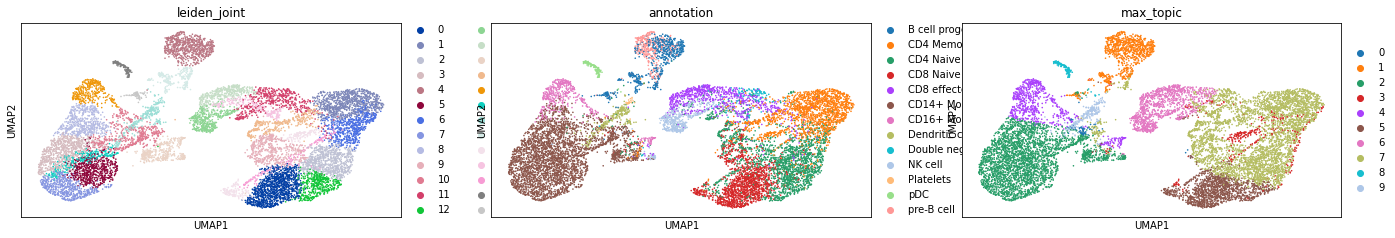

In [204]:
sc.pl.umap(mu_data, color=["leiden_joint", "annotation", "max_topic"])


## intNMF plotting functions

As well as using muons plotting functions, the intNMF package has its own plotting capabilities in its plotting module.


### View matrices

.view_embed and .view_loadings and be used to visualise theta, phi_rna and phi_atac


0.0008483922965979468


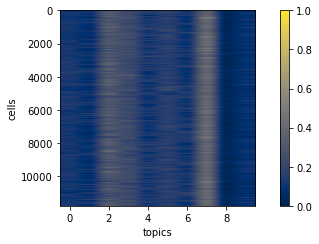

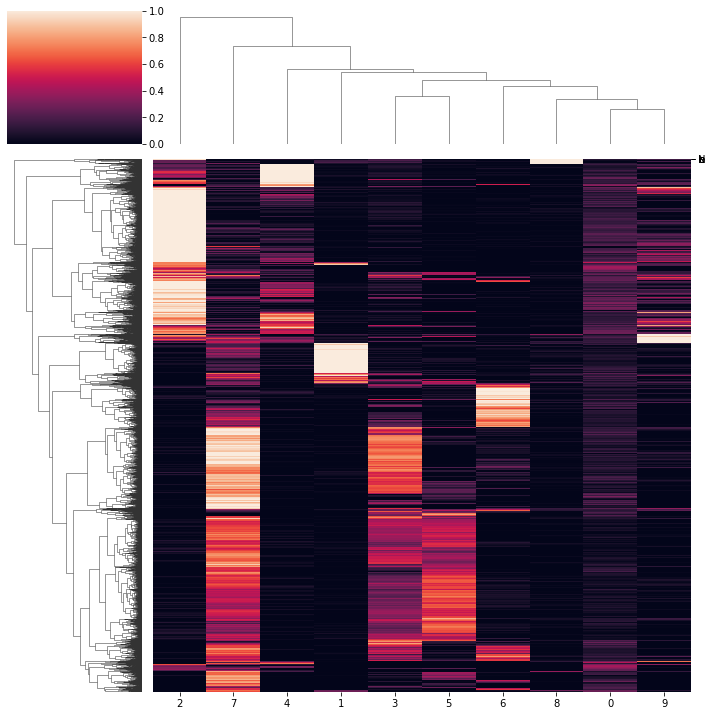

In [205]:
pl.view_embed(nmf_model)
pl.view_embed(nmf_model, clustered=True)

3660.1
10837.7


/mnt/fls01-home01/j72687wm/nmf_models/nmf_models/plotting.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


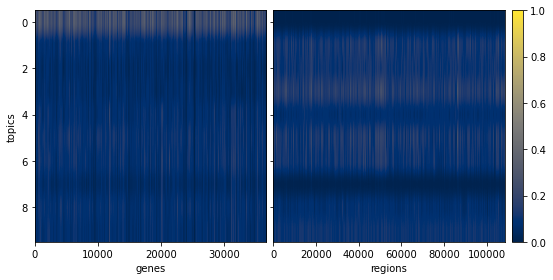

In [206]:
ax = pl.view_loadings(nmf_model, 'both') #can also view a single modality with atac or rna

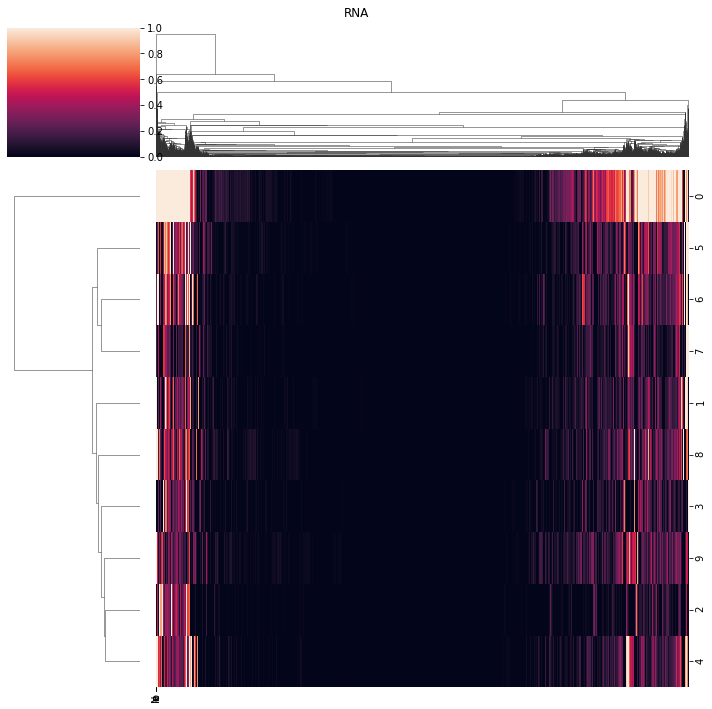

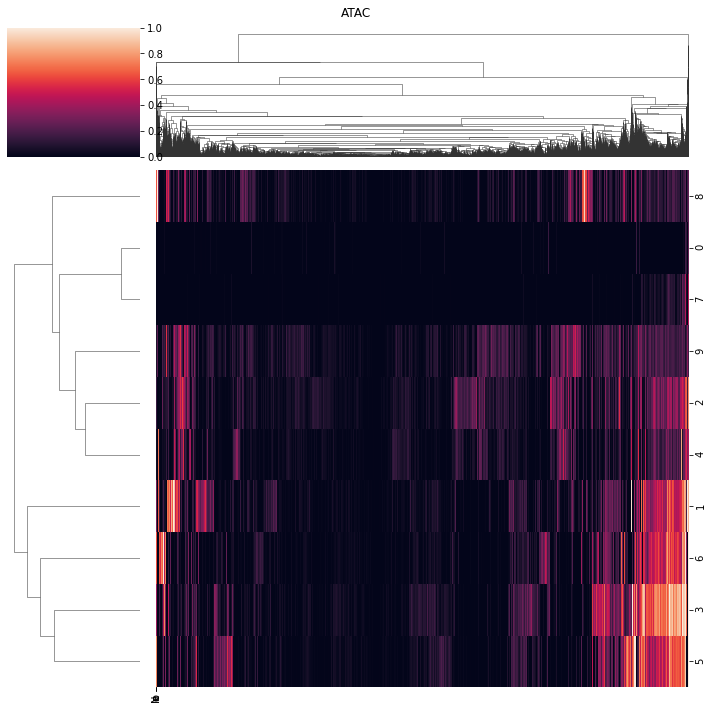

In [207]:
ax = pl.view_loadings(nmf_model, 'both', clustered=True) #can also view a single modality with atac or rna

### View correlations

topic correlations can be visualised at the topic activity level (theta) or the feature level (phi_atac and phi_rna). Again clustered on unclustered. 

default is to plot both modalities, but a single modality can be selected with modality = 'atac' or 'rna'

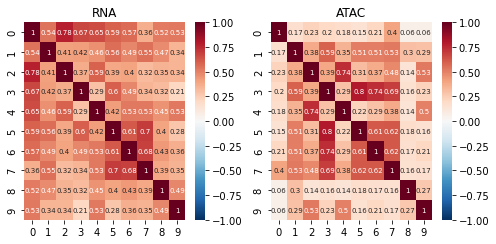

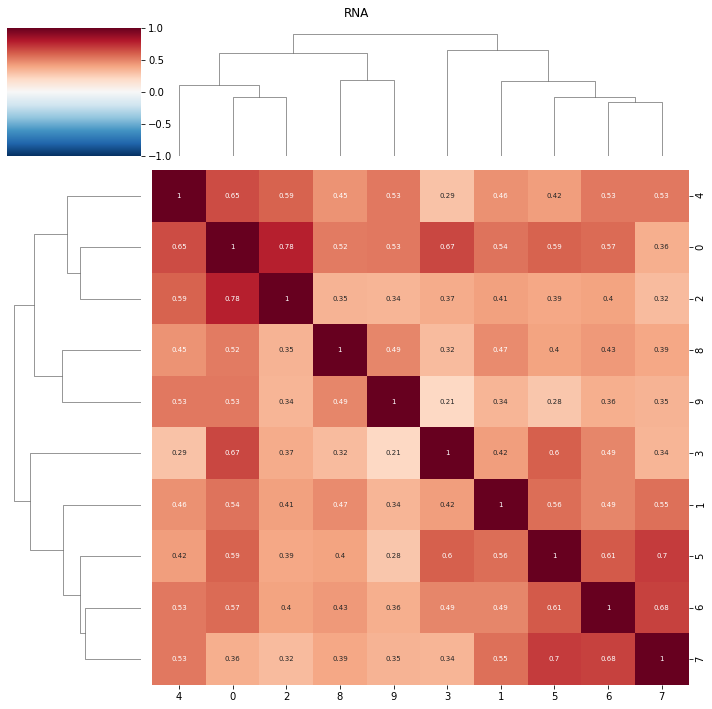

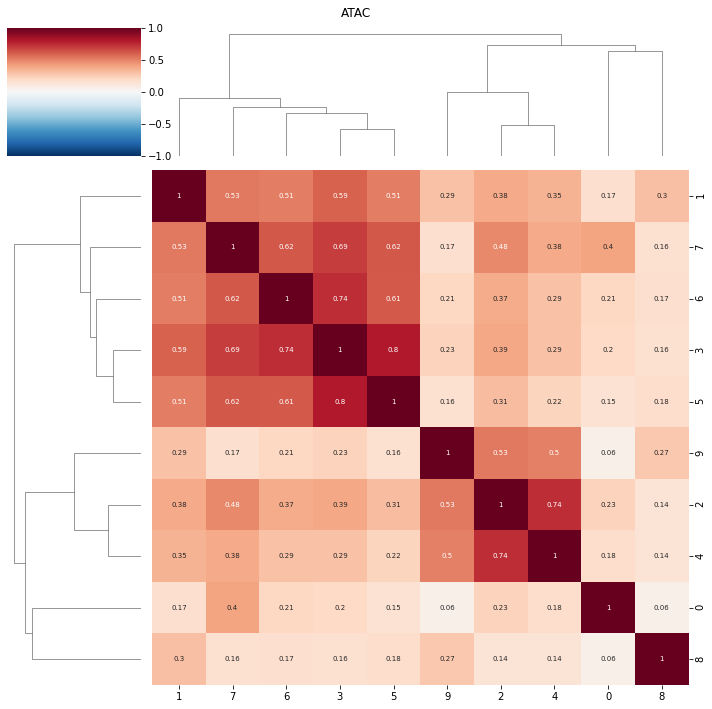

In [220]:
ax = pl.correlation_loadings(nmf_model, clustered=False)
ax = pl.correlation_loadings(nmf_model, clustered=True)

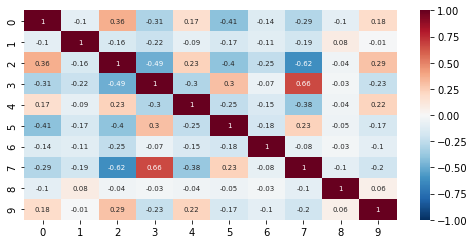

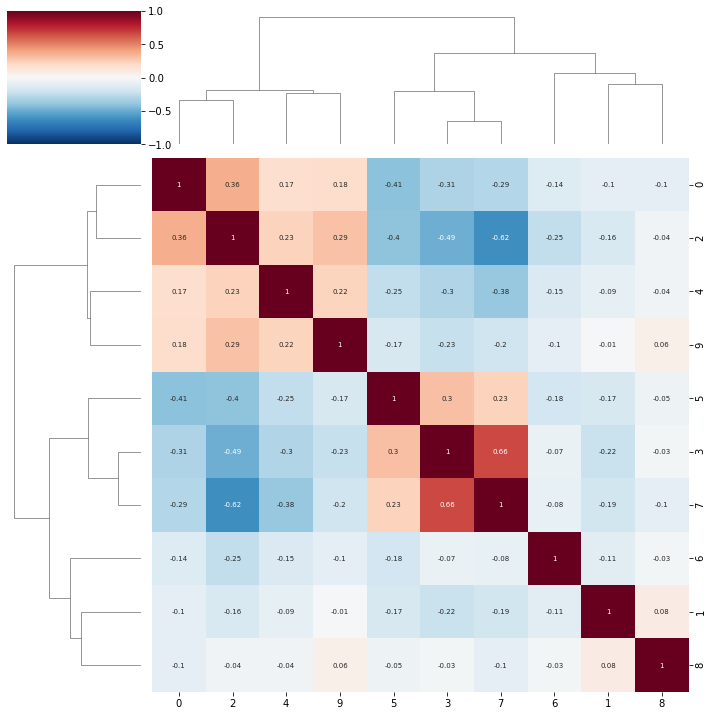

In [218]:
pl.correlation_embed(nmf_model, clustered=False)
pl.correlation_embed(nmf_model, clustered=True)

### NMF feature plots

We can also create plots which use the NMF embedding to generate scatter plots and colour cells by values. Because NMF is a linear method, unlike UMAP, we can project features onto these plots.

#### Bi plots

The defualt behavious of plotting.factor_biplot is to plot factor/topic 0 and 1, take the features with the largest absolute contribution to these topics and plot no labels. In this example I use diff as the mode which takes the feature with the largest difference between the two topics being plotted. As this dataset has annotated cell types I've also coloured the cells by their type.

<AxesSubplot:xlabel='Factor 0', ylabel='Factor 1'>

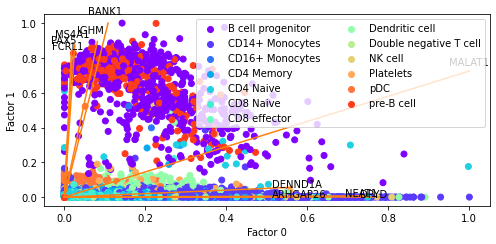

In [223]:
pl.factor_biplot(nmf_model, TX=0, TY=1, mode = 'diff', labs=mu_data.obs['annotation'])

We can also do the same but with ATAC features annotated. Possibly less informative but we can copy and paste the values into the genome browser to see the nearby genes.

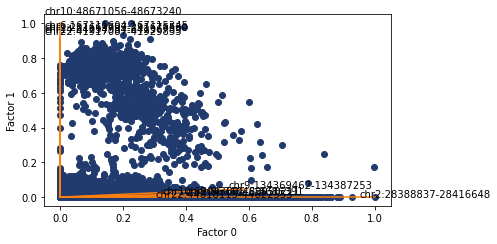

In [271]:
ax, top_features = pl.factor_biplot(nmf_model, TX=0, TY=1, mode = 'diff', modality='atac', n_labs=5)


Here I look at the size of the atac regions provdided by abs and diff compared to all of the atac regions. Both methods are skewed towards larger regions, but abs suffers more from this. 

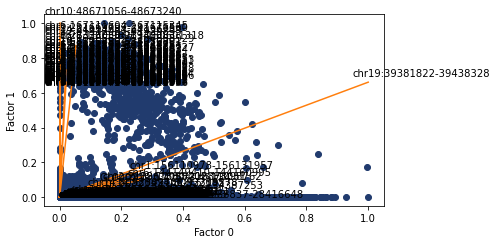

In [268]:
ax, top_features = pl.factor_biplot(nmf_model, TX=0, TY=1, mode = 'diff', modality='atac', n_labs=100)

diff = [el.split(':')[1].split('-') for el in nmf_model.atac_features]
diff = [int(el[1]) - int(el[0]) for el in diff]

diff_top = [el.split(':')[1].split('-') for el in top_features]
diff_top = [int(el[1]) - int(el[0]) for el in diff_top]

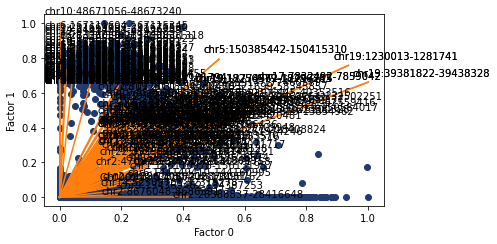

In [269]:
ax, top_features_abs = pl.factor_biplot(nmf_model, TX=0, TY=1, mode = 'abs', modality='atac', n_labs=100)

diff = [el.split(':')[1].split('-') for el in nmf_model.atac_features]
diff = [int(el[1]) - int(el[0]) for el in diff]

abs_top = [el.split(':')[1].split('-') for el in top_features_abs]
abs_top = [int(el[1]) - int(el[0]) for el in abs_top]

In [302]:
print(min(diff))
print(max(diff))

print(["{0:f}".format(i) for i in np.quantile(np.array(diff), np.linspace(0, 1, num=10))])

1
56506
['1.000000', '254.000000', '380.000000', '463.000000', '572.000000', '749.000000', '1030.000000', '1544.000000', '2556.000000', '56506.000000']


In [292]:
max(diff)

56506

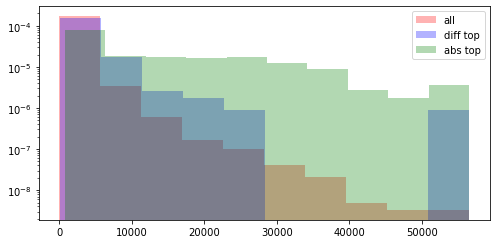

In [286]:
plt.hist(diff, log=True, density=True, alpha=0.3, color='r', label='all')
plt.hist(diff_top, log=True, density=True, alpha=0.3, color='b', label='diff top')
plt.hist(abs_top, log=True, density=True, alpha=0.3, color='g', label='abs top')
plt.legend()


#### Weight rankings

Plot the weight values for a given topic

<AxesSubplot:xlabel='Feature rank', ylabel='Factor loading'>

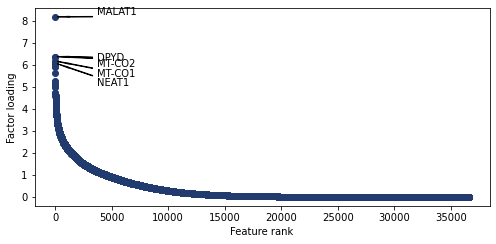

In [228]:
pl.plot_weights_rank(nmf_model, 0)

Plot the top features for all topics. You can also annotate plots with user chosen features 

In [229]:
'HNF4A' in nmf_model.rna_features

True

adding genes
adding genes
adding genes
adding genes
adding genes
adding genes
adding genes
adding genes
adding genes
adding genes


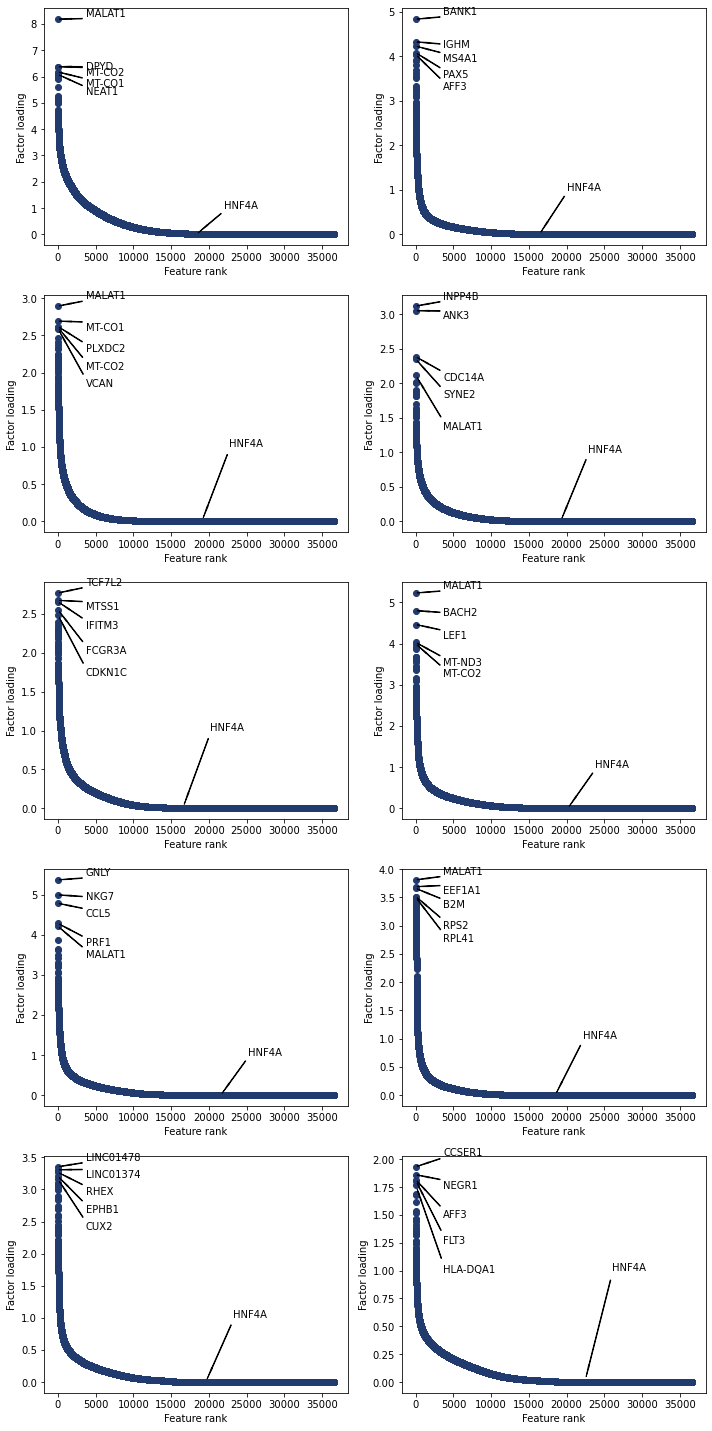

In [230]:
select = ['HNF4A']
fig, axs = plt.subplots(nrows=5, ncols=2, figsize = (10,20))
for i, ax in enumerate(axs.reshape(-1)):
    pl.plot_weights_rank(nmf_model, i, ax=ax, select=select)

The functions also work for atac features

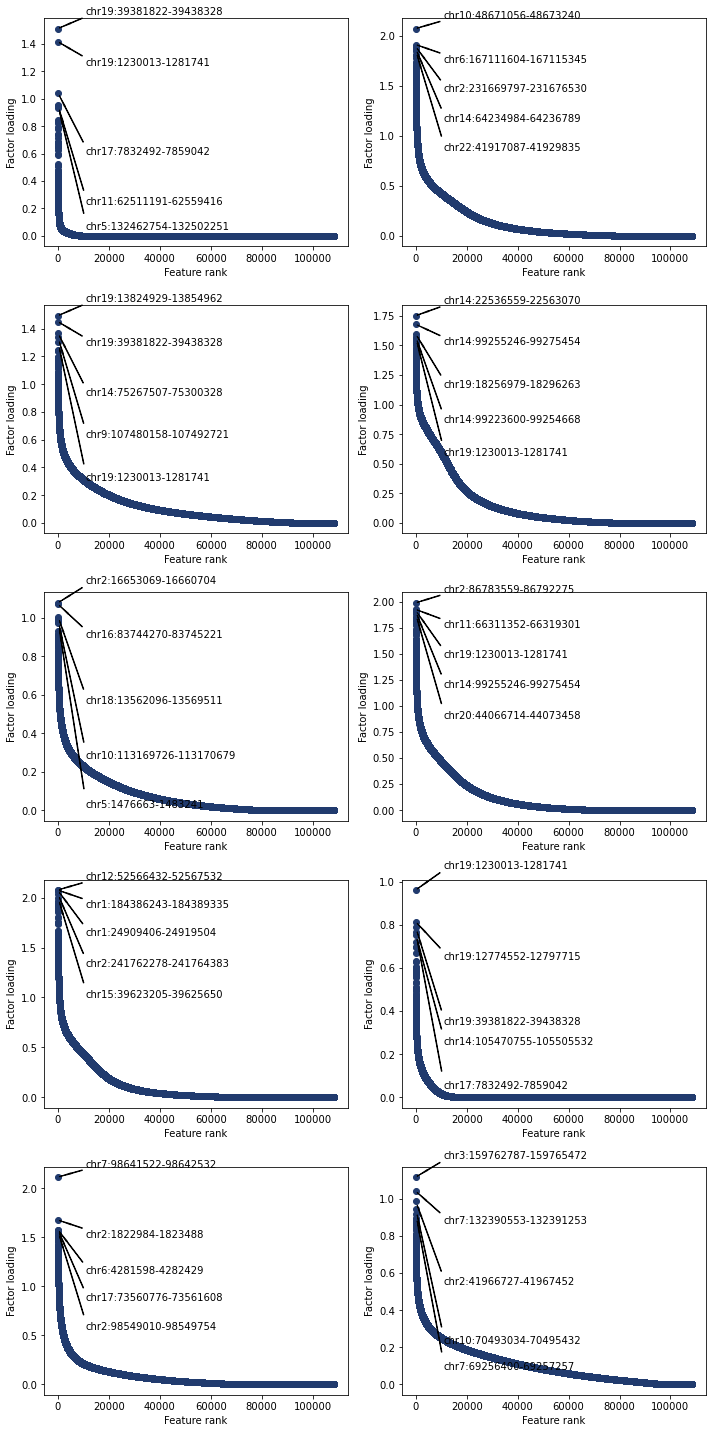

In [231]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize = (10,20))
for i, ax in enumerate(axs.reshape(-1)):
    pl.plot_weights_rank(nmf_model, i, ax=ax, modality='atac')

#### Weight scatter plots

In addition to rank plots we can compare a features weights between multiple factors/topics. While annotating the features with the highest absolute values. The key arguments for this function are nmf_model and a tuple of the factors to use as the axis

<AxesSubplot:xlabel='Factor 0', ylabel='Factor 1'>

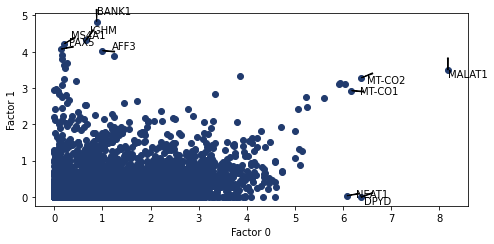

In [276]:
pl.plot_weights_scatter(nmf_model, (0, 1))

#### weights bar charts

For a list of genes plot their weights in factors of interest. We need a list of genes to plot. utils.get_top_features() can be used to do this. The only required arg is an intNMF model. Optional args include topics, n_features, modality and mode. The default behavious to use all topics, return the top feature, use the rna modality and take the absolute value.

In [277]:
top_genes_diff= utils.get_top_features(nmf_model, mode='diff', n_features=4)

In [278]:
top_genes_abs= utils.get_top_features(nmf_model, mode='abs', n_features=4)

In [279]:
top_genes

['MALAT1',
 'VCAN',
 'CDKN1C',
 'MALAT1',
 'LEF1',
 'INPP4B',
 'BANK1',
 'RPL3',
 'LINC01374',
 'GNLY']

<AxesSubplot:>

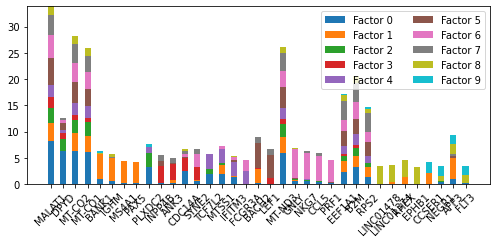

In [280]:
pl.plot_weights_bar(nmf_model, top_genes_abs)

<AxesSubplot:>

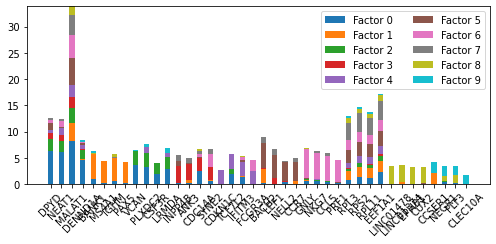

In [281]:
pl.plot_weights_bar(nmf_model, top_genes_diff)

<AxesSubplot:>

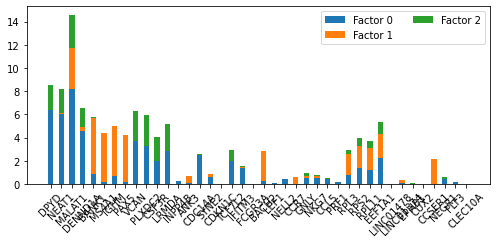

In [282]:
pl.plot_weights_bar(nmf_model, top_genes_diff, factors=[0, 1, 2])

We can also plot the loss of the nmf_model for each epoch during training (this is just qc). The loss should monotonically decrease.

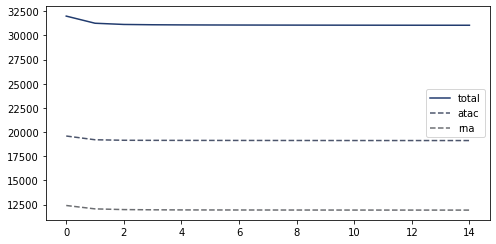

In [283]:
ax = pl.loss(nmf_model)

Finally any of nmf_model.theta, nmf_model.phi_rna and nmf_model.phi_atac can be clustered. For example hierarchical clustering of the phi_rna matrix. Groups topics based on similarity of the feature weights. Clustering featrues takes longer as there are many more features than topic/factor.

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [85.0, 85.0, 95.0, 95.0],
  [62.5, 62.5, 90.0, 90.0],
  [14.375, 14.375, 76.25, 76.25]],
 'dcoord': [[0.0, 0.30100000000000005, 0.30100000000000005, 0.0],
  [0.0, 0.394, 0.394, 0.30100000000000005],
  [0.0, 0.508, 0.508, 0.394],
  [0.0, 0.6599999999999999, 0.6599999999999999, 0.508],
  [0.0, 0.21799999999999997, 0.21799999999999997, 0.0],
  [0.0, 0.41000000000000003, 0.41000000000000003, 0.21799999999999997],
  [0.0, 0.508, 0.508, 0.0],
  [0.41000000000000003, 0.6599999999999999, 0.6599999999999999, 0.508],
  [0.6599999999999999, 0.791, 0.791, 0.6599999999999999]],
 'ivl': ['3', '1', '6', '5', '7', '4', '0', '2', '8', '9'],
 'leaves': [3, 1, 6, 5, 7, 4, 0, 2, 8, 9],
 'color_list': ['C1', 'C1', 'C1', 'C0', 'C2', 'C2', 'C3', 'C0', 'C0'],
 'leaves_color_list': ['C0',
  'C1',
  'C1',
  'C1',
  'C1',
  'C2',
  'C2

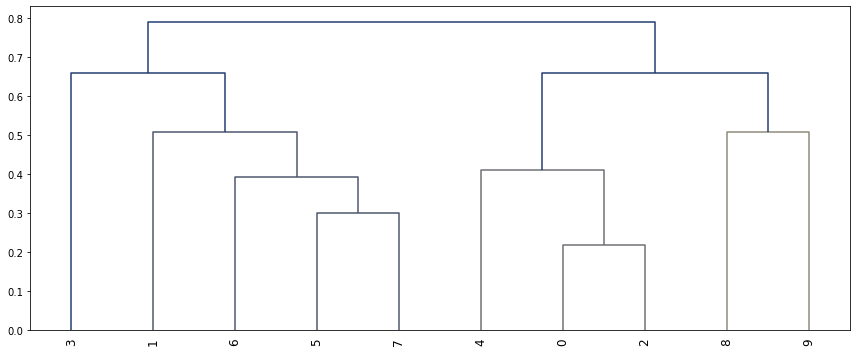

In [284]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import seaborn as sns

plt.figure(figsize=(12,5))
corr_mat = np.round(np.corrcoef(nmf_model.phi_rna), 3)
dissimilarity = 1 - abs(corr_mat)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, orientation='top', 
           leaf_rotation=90)


Threshold is a horizontal line on the above graph

In [285]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, 0.5, criterion='distance')

# Show the cluster
labels

array([4, 2, 4, 3, 4, 1, 1, 1, 5, 6], dtype=int32)